# Lamda data

In [7]:
import torch
import pyro
import pyro.distributions as dist
from pyro import param
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from cosmos.models import Tracker

In [8]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

### Results

Tracker v1.1.4prox

In [9]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])

rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

# calculate signal-to-noise ratio
heights = ["3000"]
snr = []
for h in heights:
    weights = rv.log_prob(ij_pixel).exp()
    signal = (weights ** 2 * float(h)).sum()
    noise = ((signal+background) * gain).sqrt()
    snr.append(float(signal / noise))

In [10]:
pi_z = "15"
params_last = {}
predictions = {}
labels = {}

names = ["01", "03", "15", "50", "85", "99"]

In [11]:
snr = []

for name in names:
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    path_params = "/shared/centaur/data/lamda_data/h3000pi15lamda{}/runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5".format(name)
    model = Tracker(S=1)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    snr.append(float(model.snr().mean()))

In [12]:
for name in names:
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_data, "runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5/predictions.npy"))
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))

In [21]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
scores_v1p13["SNR"] = snr
scores_v1p13["pi_naive"] = scores_v1p13.apply(lambda x: (x.TP + x.FP)/(15*500), axis=1)
scores_v1p13

,iter,-ELBO,proximity_0,gain,pi_1,lamda_1,offset_samples_0,offset_weights_0,MCC,Recall,Precision,FN,TP,TN,FP,SNR,pi_naive
01,29800.0,14390221.0,0.5,7.044241,0.161282,0.008173,89.500015,1.0,0.994963,1.000000,0.991518,0.0,1169.0,6321.0,10.0,0.01,0.157200
03,29800.0,14403316.0,0.5,7.039243,0.164633,0.024720,89.500015,1.0,0.988998,1.000000,0.981528,0.0,1169.0,6309.0,22.0,0.03,0.158800
15,19800.0,14512133.0,0.5,7.282000,0.170712,0.127169,89.500015,1.0,0.956265,1.000000,0.927778,0.0,1169.0,6240.0,91.0,0.15,0.168000
50,29800.0,14670762.0,0.5,7.247830,0.172116,0.454612,89.500015,1.0,0.897192,0.977759,0.854260,26.0,1143.0,6136.0,195.0,0.50,0.178400
85,29800.0,14809739.0,0.5,7.228729,0.169646,0.773886,89.500015,1.0,0.874864,0.970060,0.826531,35.0,1134.0,6093.0,238.0,0.85,0.182933
99,29800.0,14866692.0,0.5,7.266937,0.173179,0.900357,89.500015,1.0,0.861228,0.962361,0.812274,44.0,1125.0,6071.0,260.0,0.99,0.184667


In [19]:
sp_results = {}

for name in names:
    sp_results[name] = loadmat("/shared/centaur/data/lamda_data/lamda{}.mat".format(name))

In [20]:
scores_sp = pd.DataFrame(data={
    "spMCC": [matthews_corrcoef(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]) for name in names],
    "spRecall": [recall_score(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]) for name in names],
    "spPrecision": [precision_score(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]) for name in names],
    "TN": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[0] for name in names],
    "FP": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[1] for name in names],
    "FN": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[2] for name in names],
    "TP": [confusion_matrix(labels[name]["z"].ravel(), sp_results[name]["a"][:, 1]).ravel()[3] for name in names],
                    },
             index=names)
scores_sp["pi_naive"] = scores_sp.apply(lambda x: (x.TP + x.FP)/(15*500), axis=1)
scores_sp

,spMCC,spRecall,spPrecision,TN,FP,FN,TP,pi_naive
01,0.987974,0.998289,0.981497,6309,22,2,1167,0.158533
03,0.978047,0.994012,0.969141,6294,37,7,1162,0.159867
15,0.938699,0.976048,0.921648,6234,97,28,1141,0.165067
50,0.857590,0.932421,0.832061,6111,220,79,1090,0.174667
85,0.792527,0.882806,0.774194,6030,301,137,1032,0.177733
99,0.758779,0.855432,0.745712,5990,341,169,1000,0.178800


In [14]:
snr = [float(name)/100 for name in names]

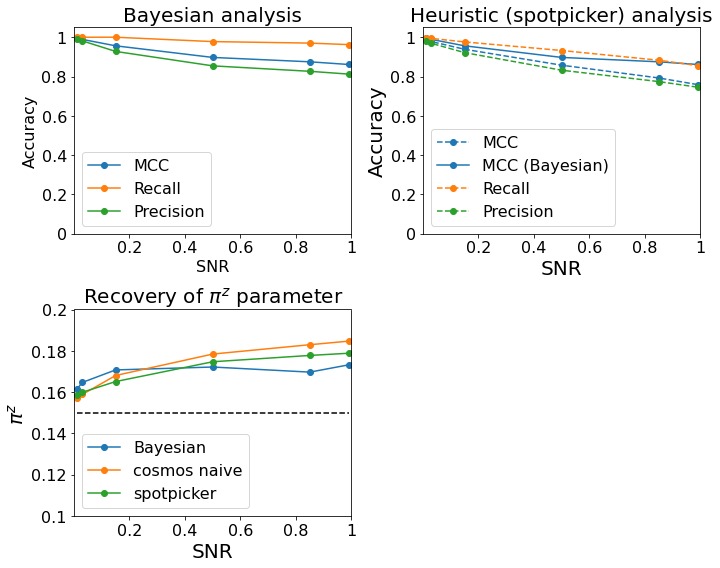

In [28]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"SNR", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,6)*0.2)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,6)*0.2)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.subplot(223)
plt.plot(snr, scores_v1p13["pi_1"], "o-", label="Bayesian")
plt.plot(snr, scores_v1p13["pi_naive"], "o-", label="cosmos naive")
plt.plot(snr, scores_sp["pi_naive"], "o-", label="spotpicker")
plt.plot([snr[0], snr[-1]], [float(pi_z)/100, float(pi_z)/100], "--", c="k")
plt.ylim(0.1,0.2)
plt.xlim(0,1)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel(r"$\pi^z$", fontsize=20)
plt.title(r"Recovery of $\pi^z$ parameter", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,6)*0.2)
#plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

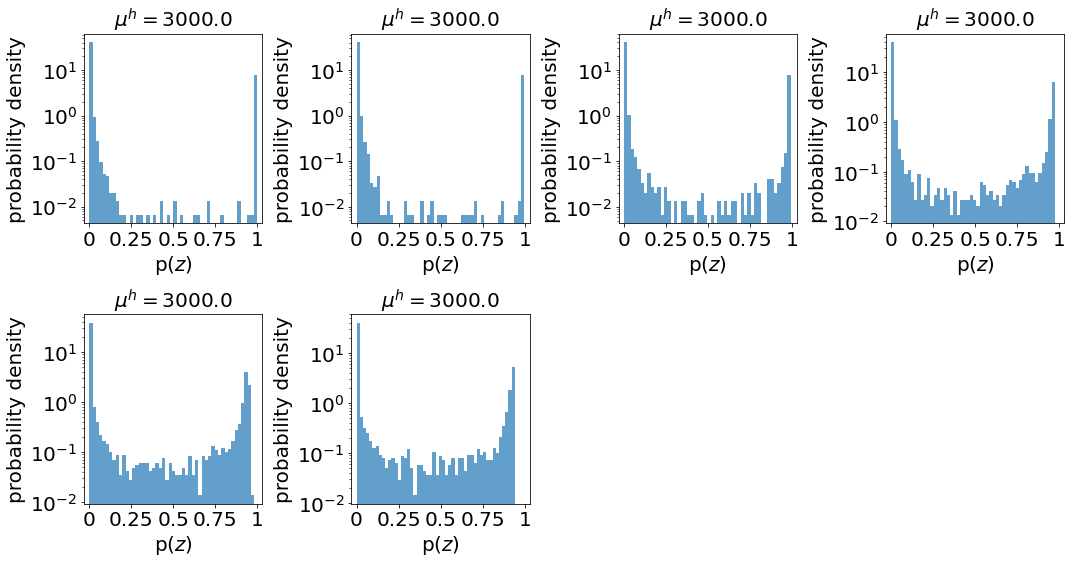

In [12]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[name]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

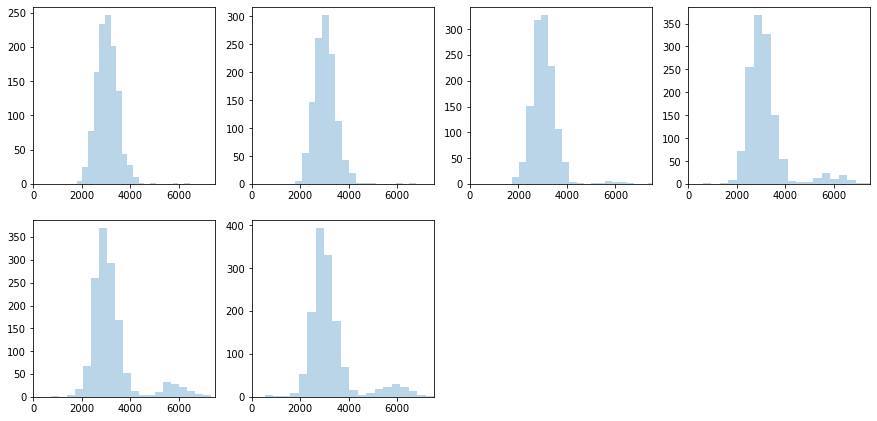

In [13]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/h_loc").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 7500)
plt.show()

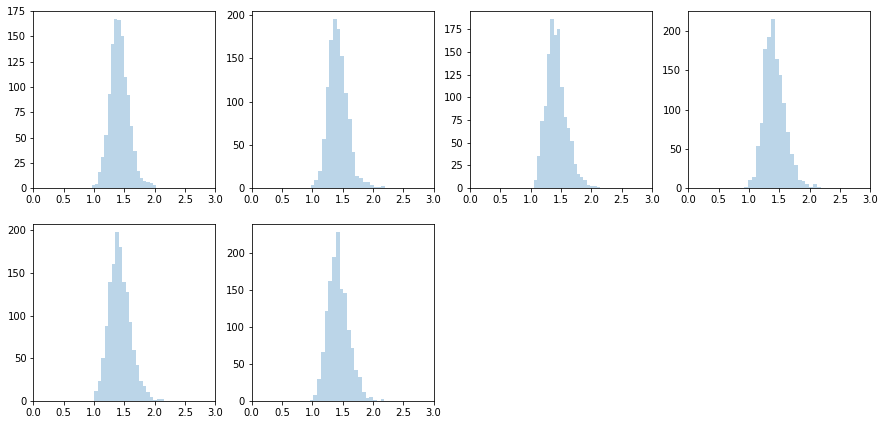

In [14]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/w_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 3)
plt.show()

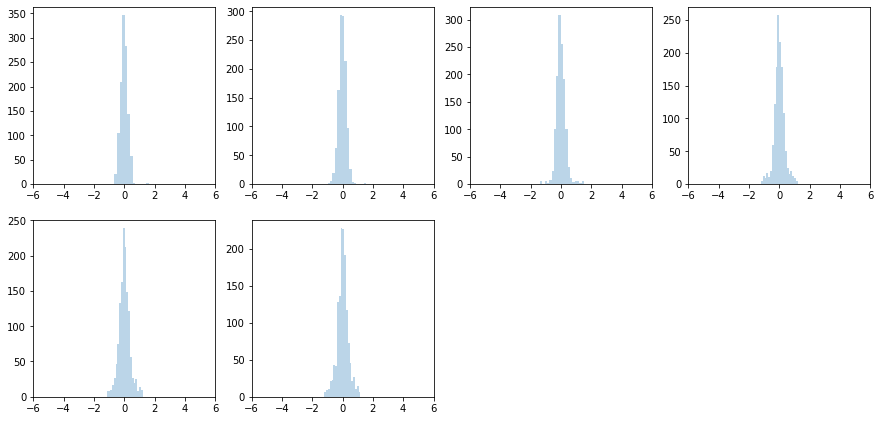

In [15]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/x_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(-6, 6)
plt.show()

In [5]:
# load cosmos results
name = "99"
path_data = "/shared/centaur/data/lamda_data/h3000pi15lamda{}".format(name)
path_params = "/shared/centaur/data/lamda_data/h3000pi15lamda{}/runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5".format(name)
model = Tracker(S=1)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

torch.Size([155, 14, 14])


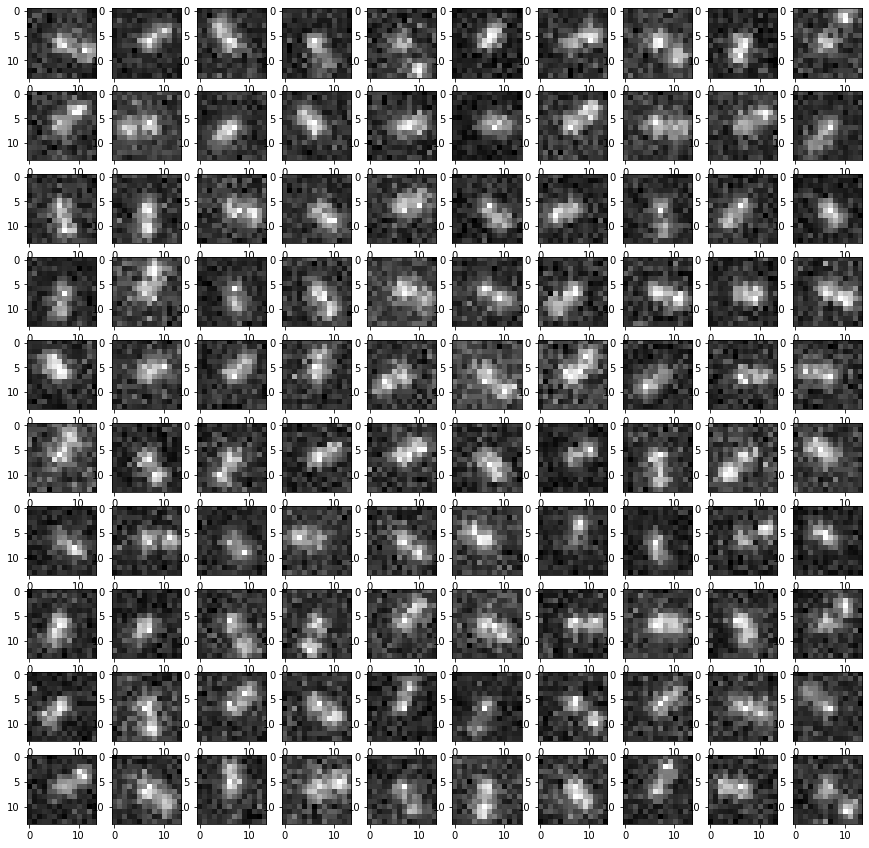

In [17]:
# spots detected by cosmos and missed by spotpicker
mask = ((model.data.labels["z"] & model.predictions["z"] & ~sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

torch.Size([30, 14, 14])


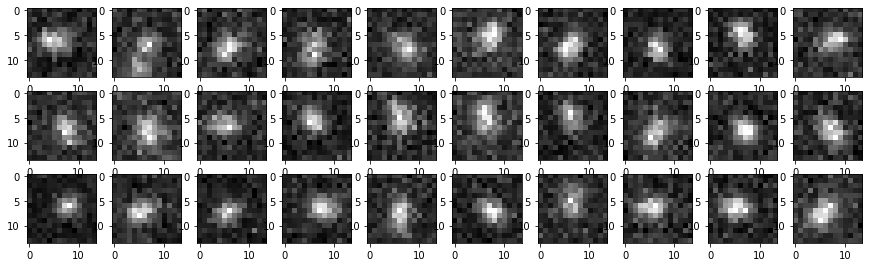

In [18]:
# spots detected by spotpicker and missed by cosmos
mask = ((model.data.labels["z"] & ~model.predictions["z"] & sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

torch.Size([14, 14, 14])


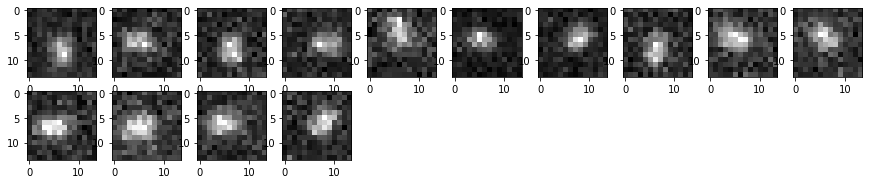

In [19]:
# spots missed by both cosmos and spotpicker
mask = ((model.data.labels["z"] & ~model.predictions["z"] & ~sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, i+1)
    plt.imshow(result[i].numpy(), cmap="gray")
plt.show()

torch.Size([14, 14, 14])


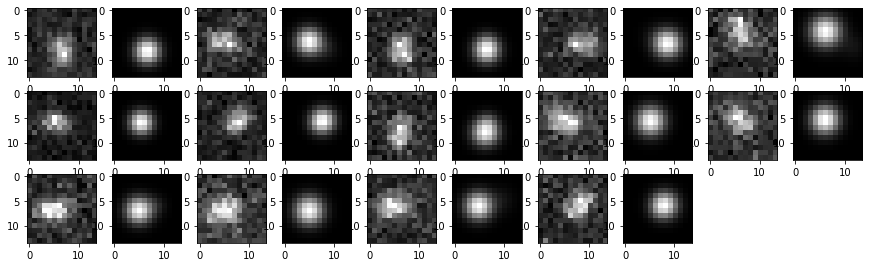

In [20]:
n, f = np.nonzero(mask)

# spots missed by both cosmos and spotpicker
mask = ((model.data.labels["z"] & ~model.predictions["z"] & ~sp_results[name]["a"][:, 1].reshape(15,500) ))

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(100, len(result))):
    plt.subplot(10, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[i], f[i]],
    param("d/w_mode").data[:, n[i], f[i]],
    param("d/x_mode").data[:, n[i], f[i]],
    param("d/y_mode").data[:, n[i], f[i]],
    n[i], f[i]).sum(0)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), cmap="gray")
    
    plt.subplot(10, 10, 2*i+2)
    plt.imshow(ideal.numpy(), cmap="gray")
plt.show()

In [162]:
param("d/theta_probs").data[0, 0] @ model.theta_matrix.float()

tensor([9.2852e-01, 1.3949e-06])

In [188]:
param("d/theta_probs").data[10, 2]

tensor([9.9787e-01, 2.1256e-03, 1.0449e-06])

In [168]:
(1-model.theta_matrix.T.float()) @ param("d/theta_probs").data[0, 0]

tensor([0.0715, 1.0000])

In [177]:
# iks
t = torch.stack((1-model.theta_matrix, model.theta_matrix), dim=-1).float()

In [187]:
torch.einsum("nfi,iks->knfs", param("d/theta_probs").data, t)[:, 10, 2]

tensor([[9.9787e-01, 2.1256e-03],
        [1.0000e+00, 1.0449e-06]])

In [6]:
model.theta_probs[:, 10, 2]

tensor([[9.9868e-01, 1.3224e-03],
        [1.0000e+00, 1.2160e-07]])

In [7]:
param("d/m_probs").data[:, 10, 3]

tensor([[[1.2521e-07, 1.0000e+00],
         [0.0000e+00, 1.0000e+00]],

        [[2.4160e-06, 1.0000e+00],
         [0.0000e+00, 1.0000e+00]]])

In [6]:
model.m_probs[:, 10, 2]

tensor([[1.2615e-07, 1.0000e+00],
        [1.2089e-07, 1.0000e+00]])

In [8]:
int i;
for (i = 0; i < 10; i++) {}
int x = i;

SyntaxError: invalid syntax (<ipython-input-8-ff2b9cea1410>, line 1)